## Work
1. 請比較使用 l1, l2, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras
import itertools

# 設定 GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

/home/seanyu/.conda/envs/tf18_keras/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# 從 Keras 的內建功能中，取得 train 與 test 資料集
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1_l2

"""
建立神經網路
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=0.0, l2_ratio=0.0):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]

In [7]:
results = {}
for l1r, l2r in itertools.product(L1_EXP, L2_EXP):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with L1 = %.6f, L2 = %.6f" % (l1r, l2r))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=l1r, l2_ratio=l2r)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-%s-l2-%s" % (str(l1r), str(l2r))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with L1 = 0.010000, L2 = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=============

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 166us/step - loss: 198.8074 - acc: 0.2322 - val_loss: 41.1290 - val_acc: 0.2547
Epoch 2/50
50000/50000 [==============================] - 7s 146us/step - loss: 19.1220 - acc: 0.1173 - val_loss: 7.2877 - val_acc: 0.1000
Epoch 3/50
50000/50000 [==============================] - 8s 151us/step - loss: 4.1123 - acc: 0.0997 - val_loss: 2.6472 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 7s 144us/step - loss: 2.4857 - acc: 0.0993 - val_loss: 2.4627 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 7s 141us/step - loss: 2.4626 - acc: 0.0982 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 8s 153us/step - loss: 2.4626 - acc: 0.0984 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 7s 145us/step - loss: 2.4626 - acc: 0.0975 - val_loss: 2.462

50000/50000 [==============================] - 8s 157us/step - loss: 19.0978 - acc: 0.1214 - val_loss: 7.2845 - val_acc: 0.1000
Epoch 3/50
50000/50000 [==============================] - 8s 152us/step - loss: 4.1132 - acc: 0.0991 - val_loss: 2.6512 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 7s 144us/step - loss: 2.4866 - acc: 0.0987 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 7s 148us/step - loss: 2.4626 - acc: 0.0987 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 7s 142us/step - loss: 2.4626 - acc: 0.0976 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 7s 139us/step - loss: 2.4626 - acc: 0.0973 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 8/50
50000/50000 [==============================] - 7s 148us/step - loss: 2.4626 - acc: 0.0968 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 9/50
50000/50000 [====================

50000/50000 [==============================] - 7s 145us/step - loss: 12.1017 - acc: 0.3958 - val_loss: 11.2722 - val_acc: 0.3971
Epoch 5/50
50000/50000 [==============================] - 7s 143us/step - loss: 10.5313 - acc: 0.4043 - val_loss: 9.8158 - val_acc: 0.4105
Epoch 6/50
50000/50000 [==============================] - 7s 139us/step - loss: 9.1932 - acc: 0.4106 - val_loss: 8.5867 - val_acc: 0.4150
Epoch 7/50
50000/50000 [==============================] - 7s 147us/step - loss: 8.0552 - acc: 0.4162 - val_loss: 7.5439 - val_acc: 0.4187
Epoch 8/50
50000/50000 [==============================] - 7s 149us/step - loss: 7.0854 - acc: 0.4241 - val_loss: 6.6425 - val_acc: 0.4284
Epoch 9/50
50000/50000 [==============================] - 7s 142us/step - loss: 6.2591 - acc: 0.4267 - val_loss: 5.8925 - val_acc: 0.4239
Epoch 10/50
50000/50000 [==============================] - 7s 146us/step - loss: 5.5557 - acc: 0.4309 - val_loss: 5.2341 - val_acc: 0.4356
Epoch 11/50
50000/50000 [================

50000/50000 [==============================] - 5s 105us/step - loss: 5.2580 - acc: 0.4383 - val_loss: 5.2408 - val_acc: 0.4311
Epoch 7/50
50000/50000 [==============================] - 5s 103us/step - loss: 5.1622 - acc: 0.4514 - val_loss: 5.1274 - val_acc: 0.4501
Epoch 8/50
50000/50000 [==============================] - 5s 98us/step - loss: 5.0706 - acc: 0.4595 - val_loss: 5.0409 - val_acc: 0.4523
Epoch 9/50
50000/50000 [==============================] - 5s 96us/step - loss: 4.9822 - acc: 0.4713 - val_loss: 4.9775 - val_acc: 0.4553
Epoch 10/50
50000/50000 [==============================] - 5s 99us/step - loss: 4.8991 - acc: 0.4781 - val_loss: 4.8777 - val_acc: 0.4730
Epoch 11/50
50000/50000 [==============================] - 5s 100us/step - loss: 4.8162 - acc: 0.4863 - val_loss: 4.8406 - val_acc: 0.4599
Epoch 12/50
50000/50000 [==============================] - 5s 100us/step - loss: 4.7349 - acc: 0.4952 - val_loss: 4.7541 - val_acc: 0.4703
Epoch 13/50
50000/50000 [====================

50000/50000 [==============================] - 4s 90us/step - loss: 5.0672 - acc: 0.4625 - val_loss: 5.0532 - val_acc: 0.4522
Epoch 9/50
50000/50000 [==============================] - 5s 94us/step - loss: 4.9797 - acc: 0.4691 - val_loss: 4.9552 - val_acc: 0.4617
Epoch 10/50
50000/50000 [==============================] - 5s 98us/step - loss: 4.8950 - acc: 0.4775 - val_loss: 4.8828 - val_acc: 0.4641
Epoch 11/50
50000/50000 [==============================] - 4s 90us/step - loss: 4.8131 - acc: 0.4847 - val_loss: 4.8183 - val_acc: 0.4703
Epoch 12/50
50000/50000 [==============================] - 5s 90us/step - loss: 4.7319 - acc: 0.4929 - val_loss: 4.7430 - val_acc: 0.4744
Epoch 13/50
50000/50000 [==============================] - 5s 93us/step - loss: 4.6530 - acc: 0.5007 - val_loss: 4.6717 - val_acc: 0.4756
Epoch 14/50
50000/50000 [==============================] - 5s 94us/step - loss: 4.5766 - acc: 0.5064 - val_loss: 4.6000 - val_acc: 0.4875
Epoch 15/50
50000/50000 [======================

50000/50000 [==============================] - 5s 100us/step - loss: 1.6056 - acc: 0.4879 - val_loss: 1.6409 - val_acc: 0.4664
Epoch 11/50
50000/50000 [==============================] - 5s 101us/step - loss: 1.5817 - acc: 0.4925 - val_loss: 1.6149 - val_acc: 0.4720
Epoch 12/50
50000/50000 [==============================] - 5s 100us/step - loss: 1.5600 - acc: 0.5005 - val_loss: 1.6017 - val_acc: 0.4769
Epoch 13/50
50000/50000 [==============================] - 5s 97us/step - loss: 1.5392 - acc: 0.5102 - val_loss: 1.5884 - val_acc: 0.4855
Epoch 14/50
50000/50000 [==============================] - 5s 99us/step - loss: 1.5195 - acc: 0.5156 - val_loss: 1.5657 - val_acc: 0.4894
Epoch 15/50
50000/50000 [==============================] - 5s 98us/step - loss: 1.5004 - acc: 0.5242 - val_loss: 1.5654 - val_acc: 0.4880
Epoch 16/50
50000/50000 [==============================] - 5s 98us/step - loss: 1.4830 - acc: 0.5269 - val_loss: 1.5527 - val_acc: 0.4884
Epoch 17/50
50000/50000 [==================

50000/50000 [==============================] - 5s 95us/step - loss: 1.4170 - acc: 0.5029 - val_loss: 1.4731 - val_acc: 0.4799
Epoch 13/50
50000/50000 [==============================] - 5s 97us/step - loss: 1.3971 - acc: 0.5108 - val_loss: 1.4417 - val_acc: 0.4857
Epoch 14/50
50000/50000 [==============================] - 5s 96us/step - loss: 1.3768 - acc: 0.5175 - val_loss: 1.4491 - val_acc: 0.4790
Epoch 15/50
50000/50000 [==============================] - 5s 101us/step - loss: 1.3577 - acc: 0.5232 - val_loss: 1.4458 - val_acc: 0.4837
Epoch 16/50
50000/50000 [==============================] - 5s 97us/step - loss: 1.3397 - acc: 0.5297 - val_loss: 1.4641 - val_acc: 0.4843
Epoch 17/50
50000/50000 [==============================] - 5s 98us/step - loss: 1.3245 - acc: 0.5330 - val_loss: 1.4123 - val_acc: 0.4994
Epoch 18/50
50000/50000 [==============================] - 5s 97us/step - loss: 1.3058 - acc: 0.5405 - val_loss: 1.3934 - val_acc: 0.4977
Epoch 19/50
50000/50000 [====================

50000/50000 [==============================] - 5s 99us/step - loss: 3.4246 - acc: 0.4505 - val_loss: 3.3005 - val_acc: 0.4503
Epoch 15/50
50000/50000 [==============================] - 5s 98us/step - loss: 3.1753 - acc: 0.4554 - val_loss: 3.0779 - val_acc: 0.4505
Epoch 16/50
50000/50000 [==============================] - 5s 97us/step - loss: 2.9606 - acc: 0.4580 - val_loss: 2.8693 - val_acc: 0.4578
Epoch 17/50
50000/50000 [==============================] - 5s 99us/step - loss: 2.7754 - acc: 0.4619 - val_loss: 2.7057 - val_acc: 0.4579
Epoch 18/50
50000/50000 [==============================] - 5s 99us/step - loss: 2.6190 - acc: 0.4637 - val_loss: 2.5818 - val_acc: 0.4493
Epoch 19/50
50000/50000 [==============================] - 5s 102us/step - loss: 2.4833 - acc: 0.4683 - val_loss: 2.4467 - val_acc: 0.4551
Epoch 20/50
50000/50000 [==============================] - 5s 101us/step - loss: 2.3671 - acc: 0.4696 - val_loss: 2.3505 - val_acc: 0.4613
Epoch 21/50
50000/50000 [===================

50000/50000 [==============================] - 5s 100us/step - loss: 1.3382 - acc: 0.5285 - val_loss: 1.4037 - val_acc: 0.5004
Epoch 17/50
50000/50000 [==============================] - 5s 99us/step - loss: 1.3199 - acc: 0.5363 - val_loss: 1.4340 - val_acc: 0.4966
Epoch 18/50
50000/50000 [==============================] - 5s 102us/step - loss: 1.3014 - acc: 0.5423 - val_loss: 1.3840 - val_acc: 0.5056
Epoch 19/50
50000/50000 [==============================] - 5s 104us/step - loss: 1.2851 - acc: 0.5486 - val_loss: 1.3939 - val_acc: 0.5035
Epoch 20/50
50000/50000 [==============================] - 5s 106us/step - loss: 1.2707 - acc: 0.5541 - val_loss: 1.4118 - val_acc: 0.5005
Epoch 21/50
50000/50000 [==============================] - 5s 98us/step - loss: 1.2554 - acc: 0.5576 - val_loss: 1.3940 - val_acc: 0.5045
Epoch 22/50
50000/50000 [==============================] - 5s 99us/step - loss: 1.2381 - acc: 0.5645 - val_loss: 1.3932 - val_acc: 0.5107
Epoch 23/50
50000/50000 [=================

50000/50000 [==============================] - 4s 77us/step - loss: 1.3048 - acc: 0.5412 - val_loss: 1.4187 - val_acc: 0.4946
Epoch 19/50
50000/50000 [==============================] - 4s 77us/step - loss: 1.2899 - acc: 0.5469 - val_loss: 1.3828 - val_acc: 0.5089
Epoch 20/50
50000/50000 [==============================] - 4s 80us/step - loss: 1.2735 - acc: 0.5522 - val_loss: 1.3855 - val_acc: 0.5081
Epoch 21/50
50000/50000 [==============================] - 4s 83us/step - loss: 1.2586 - acc: 0.5567 - val_loss: 1.3922 - val_acc: 0.5060
Epoch 22/50
50000/50000 [==============================] - 4s 80us/step - loss: 1.2431 - acc: 0.5632 - val_loss: 1.3980 - val_acc: 0.5075
Epoch 23/50
50000/50000 [==============================] - 4s 77us/step - loss: 1.2272 - acc: 0.5695 - val_loss: 1.3752 - val_acc: 0.5183
Epoch 24/50
50000/50000 [==============================] - 4s 75us/step - loss: 1.2115 - acc: 0.5740 - val_loss: 1.4034 - val_acc: 0.5076
Epoch 25/50
50000/50000 [=====================

50000/50000 [==============================] - 4s 76us/step - loss: 1.4025 - acc: 0.5558 - val_loss: 1.5166 - val_acc: 0.5122
Epoch 21/50
50000/50000 [==============================] - 4s 75us/step - loss: 1.3853 - acc: 0.5613 - val_loss: 1.5215 - val_acc: 0.5126
Epoch 22/50
50000/50000 [==============================] - 4s 79us/step - loss: 1.3699 - acc: 0.5682 - val_loss: 1.5321 - val_acc: 0.5083
Epoch 23/50
50000/50000 [==============================] - 4s 79us/step - loss: 1.3569 - acc: 0.5712 - val_loss: 1.4987 - val_acc: 0.5164
Epoch 24/50
50000/50000 [==============================] - 4s 80us/step - loss: 1.3416 - acc: 0.5764 - val_loss: 1.5071 - val_acc: 0.5145
Epoch 25/50
50000/50000 [==============================] - 4s 79us/step - loss: 1.3281 - acc: 0.5838 - val_loss: 1.5155 - val_acc: 0.5187
Epoch 26/50
50000/50000 [==============================] - 4s 76us/step - loss: 1.3134 - acc: 0.5868 - val_loss: 1.4778 - val_acc: 0.5232
Epoch 27/50
50000/50000 [=====================

50000/50000 [==============================] - 4s 77us/step - loss: 1.2307 - acc: 0.5678 - val_loss: 1.3658 - val_acc: 0.5131
Epoch 23/50
50000/50000 [==============================] - 4s 76us/step - loss: 1.2148 - acc: 0.5727 - val_loss: 1.3472 - val_acc: 0.5222
Epoch 24/50
50000/50000 [==============================] - 4s 77us/step - loss: 1.2024 - acc: 0.5751 - val_loss: 1.3749 - val_acc: 0.5160
Epoch 25/50
50000/50000 [==============================] - 4s 77us/step - loss: 1.1856 - acc: 0.5822 - val_loss: 1.3938 - val_acc: 0.5078
Epoch 26/50
50000/50000 [==============================] - 4s 80us/step - loss: 1.1714 - acc: 0.5861 - val_loss: 1.3410 - val_acc: 0.5231
Epoch 27/50
50000/50000 [==============================] - 4s 80us/step - loss: 1.1575 - acc: 0.5905 - val_loss: 1.3904 - val_acc: 0.5128
Epoch 28/50
50000/50000 [==============================] - 4s 76us/step - loss: 1.1459 - acc: 0.5937 - val_loss: 1.3476 - val_acc: 0.5211
Epoch 29/50
50000/50000 [=====================

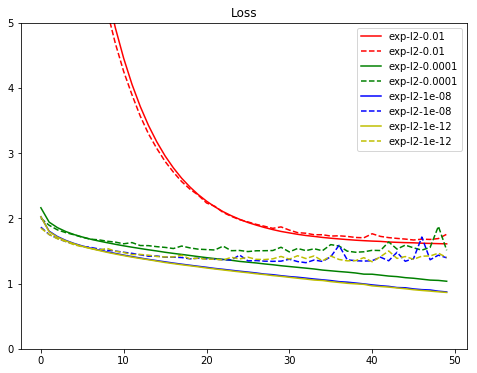

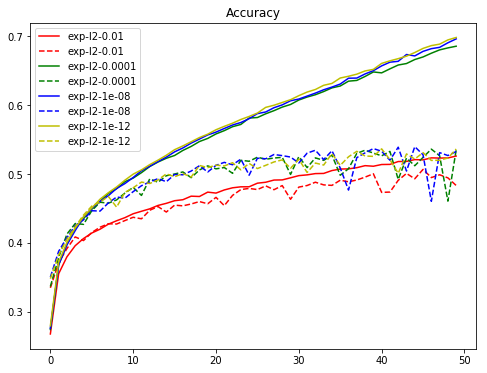

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()